In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import time
import pickle

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from pgm.data import AlignedSequencesData
from pgm.layers import GaussianLayer, OneHotLayer, dReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.metrics import aa_acc, l1b_reg, msa_mean, ZeroSumGauge

In [3]:
DATASET = "PF00397"
DATA = "/home/cyril/Documents/These/data"
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY-'

AA_IDS = {l: i for i, l in enumerate(AMINO_ACIDS)}
batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.25
gamma = lamb_l1b**2/(2*q*N)
# lamb_l2

## Data

For Proteins

In [4]:
from structure.data_extraction import from_fasta_to_df
from structure.utils import to_onehot

In [5]:
class AlignedSequencesData(object):
    def __init__(self, file):
        self.df = from_fasta_to_df(file)
        self.df["name"] = self.df.index
        self.df[self.df.name.apply(lambda x : x[0]) == "a"]
        self.raw_sequences = np.array(list(self.df.aligned_seq.apply(lambda s: np.array([AA_IDS[c] if c in AA_IDS.keys() else -1 for c in s]))))
        self.raw_sequences = self.raw_sequences[:, ((self.raw_sequences == -1).max(0) == False)] 
        self.size = self.raw_sequences.shape[1]
        self.raw_sequences = [to_onehot(seq, (self.size, len(AA_IDS))) for seq in self.raw_sequences]
        self.weights = np.ones(len(self.df.values))
        
    def __len__(self):
        return len(self.raw_sequences)
    
    def __getitem__(self, i):
        return self.raw_sequences[i], self.weights[i]

In [6]:
filename = "aligned.fasta"
train_dataset = AlignedSequencesData(f"{DATA}/{DATASET}/{filename}")
train_loader = DataLoader(train_dataset, batch_size = batch_size, 
                          shuffle = True, drop_last=True)

# val_dataset = AlignedSequencesData(f"{DATA}/rbm/val.csv")
# val_loader = DataLoader(val_dataset, batch_size = batch_size, 
#                         shuffle = True, drop_last=True)

In [138]:
pots = np.zeros((31, 21))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
q = F.softmax(torch.log(torch.FloatTensor(pots)),0)

pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).view(-1)

## Build Model

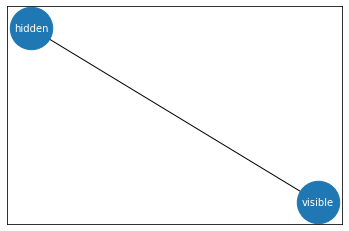

MRF(
  (layers): ModuleDict(
    (hidden): GaussianLayer()
    (visible): OneHotLayer(
      (linear): Linear(in_features=651, out_features=1, bias=True)
    )
  )
  (edges): ModuleDict(
    (visible -> hidden): Edge(
      (in_layer): OneHotLayer(
        (linear): Linear(in_features=651, out_features=1, bias=True)
      )
      (out_layer): GaussianLayer()
      (linear): Linear(in_features=651, out_features=20, bias=False)
      (reverse): Linear(in_features=20, out_features=651, bias=False)
      (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [139]:
device = torch.device('cpu')

visible = OneHotLayer(pots, N = 31, q = 21, name = "visible").to(device)
hidden = GaussianLayer(N = 20, name = "hidden").to(device)

E = [(visible.name, hidden.name)]

model = MRF(layers = {visible.name: visible, 
                    hidden.name: hidden},
         edges = E).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
model

In [149]:
ais = AIS(model, q).T


In [ ]:
start = time.time()
model.train()
in_lays, out_lays = ["visible"], ["hidden"]
edge = model.get_edge("visible", "hidden")
edge.gauge = edge.gauge.to(device)
ais = AIS(model, q)

for epoch in range(6000):
    mean_loss, mean_reg, mean_acc = 0, 0, 0
    for batch_idx, data in enumerate(train_loader):
        x = data[0].float().permute(0, 2, 1).to(device)
        w = data[1].float().to(device)
        
        # Sampling
        d_0 = {"visible":x}
        d_0, d_f = model.gibbs_sampling(d_0, in_lays, out_lays, k = 10)
        
        # Optimization
        optimizer.zero_grad()
        e_0, e_f = model(d_0), model(d_f)
        reg = l1b_reg(edge)
        loss = msa_mean(e_f-e_0, w) + gamma * reg
        loss.backward()
        optimizer.step()
        
        # Z estimation
        if not epoch%100 and not batch_idx:
            ais.update(model)
            Z = ais.run(50, 100)
        
        # Metrics
#         d_0, d_f = model.gibbs_sampling(d_0, in_lays, out_lays, k = 1)
        acc = aa_acc(d_0["visible"].view(*x.size()), d_f["visible"].view(*x.size()))
        ll = msa_mean(model.integrate_likelihood(d_f, "hidden"),w)/31
        mean_loss = (mean_loss*batch_idx + ll.item())/ (batch_idx+1)
        mean_reg = (mean_reg*batch_idx + gamma*reg)/(batch_idx+1)
        mean_acc = (mean_acc*batch_idx + acc)/(batch_idx+1)
        m, s = int(time.time()-start)//60, int(time.time()-start)%60

    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s} || Loss: {mean_loss-Z:.3f} || Reg: {mean_reg:.3f} || Acc: {mean_acc:.3f}''', end="\r")
#     if not epoch % 50:
#         data = next(iter(val_loader))
#         x = data[0].float().permute(0, 2, 1).to(device)
#         x_f, _, mut, _ = edge.gibbs_step(x, sample=False)
#         acc = aa_acc(x, mut.view(batch_size, q, N))
#         m, s = int(time.time()-start)//60, int(time.time()-start)%60
#         print(f'''Val: {epoch} || Time: {m} min {s} || Loss: {mean_loss:.2f} || Reg: {mean_reg:.2f} || Acc: {mean_acc:.2f} ||  Val Acc : {acc:.3f}''')

Estimated Z : 2.497
Estimated Z : 4.6050%] || Time: 2 min 50 || Loss: 0.318 || Reg: 1.408 || Acc: 0.4622
Estimated Z : 4.85500%] || Time: 5 min 41 || Loss: -1.513 || Reg: 1.698 || Acc: 0.479
Estimated Z : 4.87400%] || Time: 8 min 25 || Loss: -1.605 || Reg: 1.699 || Acc: 0.485
Estimated Z : 5.08600%] || Time: 11 min 8 || Loss: -1.539 || Reg: 1.684 || Acc: 0.4898
Estimated Z : 5.07000%] || Time: 14 min 1 || Loss: -1.664 || Reg: 1.668 || Acc: 0.4898
Estimated Z : 5.57400%] || Time: 16 min 48 || Loss: -1.595 || Reg: 1.660 || Acc: 0.489
Estimated Z : 5.42400%] || Time: 20 min 4 || Loss: -2.033 || Reg: 1.653 || Acc: 0.4909
Estimated Z : 5.57300%] || Time: 23 min 28 || Loss: -1.823 || Reg: 1.648 || Acc: 0.490
Estimated Z : 5.55900%] || Time: 26 min 48 || Loss: -1.942 || Reg: 1.641 || Acc: 0.489
Estimated Z : 5.80500%] || Time: 30 min 18 || Loss: -1.866 || Reg: 1.629 || Acc: 0.491
Estimated Z : 5.344100%] || Time: 33 min 40 || Loss: -2.037 || Reg: 1.624 || Acc: 0.491
Estimated Z : 5.584100%] |

In [64]:
from torch.distributions.one_hot_categorical import OneHotCategorical
import math

In [167]:
class AIS(object):
    def __init__(self,  model, p_0, edges = []):
        super(AIS, self).__init__()
        self.q, self.N = p_0.size()
        self.p_0 = p_0.view(-1)
        self.log_p_0 = torch.log(self.p_0+1e-8)
        edge = model.get_edge("visible","hidden")
        self.gammaI = lambda x : model.layers["hidden"].gamma(edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)
        self.distribution = OneHotCategorical(p_0.t())
    
    def update(self, model):
        edge = model.get_edge("visible","hidden")
        self.gammaI = lambda x : model.layers["hidden"].gamma(edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)

    def run(self, n_samples, n_inter, verbose = 0):
        betas = torch.linspace(0, 1, n_inter)
        samples = self._sample(n_samples)
        logp0 = self.log_f0(samples)
#         weights = torch.zeros(n_samples)
        for i,beta in enumerate(betas[1:]):
            samples = self.T(samples, lambda x: self.log_fj(x, beta), n_steps=10)
#             weights += log_fj(samples, beta) - log_fj(samples, last_beta)
            logpn = self.log_fj(samples, beta)
            if verbose and not i%100:
                print(f"Iteration {i}")
            last_beta = beta
        logpn = self.log_fn(samples)
        Z = ((logpn - logp0).logsumexp(0) - math.log(n_samples))/self.N
        print(f"Estimated Z : {Z:.3f}")
        return Z

    def _sample(self, n_samples):
        return self.distribution.sample((n_samples,)).permute(0,2,1).reshape(n_samples, -1)

    def log_f0(self,x):
        return (self.log_p_0*x).sum(-1)

    def log_fn(self, x):
        ll = (x * self.W).sum(-1)
        ll += self.gammaI(x)
        return ll.detach()

    def log_fj(self, x, beta):
        return self.log_f0(x) * beta + self.log_fn(x)*(1-beta)

    def probs(self, x):
        return (self.p_0.view(1,-1)*x).view(-1,self.q,self.N).permute(0,2,1)
    
    def T(self, x, f, n_steps = 10):
        n_samples = x.size(0)
        for t in range(n_steps):
            x_prime = OneHotCategorical(self.probs(x)).sample().permute(0,2,1).reshape(n_samples, -1)
            a = f(x_prime) - f(x)
            idx = torch.where(torch.rand_like(a) < torch.exp(a))[0]
            x[idx] = x_prime[idx]
        return x

In [142]:
ais_ = AIS(model, q)

In [132]:
ais_.update(model)

In [96]:
logpn = log_fn(samples)
Z = (F.log_softmax(weights) + logpn - logp0).logsumexp(0)/31
Z

tensor(4.5663)

In [117]:
F.log_softmax(weights), logpn - logp0

(tensor([-1010.0593,  -453.6169,   -75.5941,   -30.1659,  -732.1194,  -578.5587,
          -543.8281,  -537.0428,  -178.9714,  -680.0652,  -679.7471,  -454.3023,
          -590.3973, -1321.6151,     0.0000,  -711.8146,  -535.9572, -1078.3324,
          -508.5076,  -683.5151]),
 tensor([140.9662, 143.1859, 118.0419, 126.4386, 130.2012, 152.7874, 135.1541,
         125.2087, 118.6375, 160.1119, 140.6018, 127.2794, 133.7686, 150.9615,
         141.5560, 112.0823, 112.8044, 146.1756, 125.4359, 148.1181]))

In [119]:
Z = 141.5560/31

In [111]:
Z = ((logpn - logp0).logsumexp(0) - math.log(20))/31
Z

tensor(5.0683)

## Visualize

In [ ]:
import sys

ROOT = "/home/cyril/Documents/These"
sys.path.append(f"{ROOT}/paper_codes/PGM3/source/")
sys.path.append(f"{ROOT}/paper_codes/PGM3/utilities/")

import Proteins_utils, RBM_utils, utilities10 as utilities, sequence_logo, plots_utils

def get_beta(W,include_gaps=False):
    if not include_gaps:
        W_ = W[:,:,:-1]
    else:
        W_ = W
    return  np.sqrt( (W_**2).sum(-1).sum(-1) ).numpy()

In [ ]:
max_acti = model.edges[("visible", "hidden")].get_weights().detach().view(-1, 21, 31).permute(0,2,1)
order = np.argsort(get_beta(max_acti))[::-1]

In [ ]:
fig = sequence_logo.Sequence_logo_multiple(max_acti.numpy()[order], figsize=(15,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);